In [1]:
### IMPORTS ### 
folder0 = '/home/how09898/phd/jupyter/floquet-bloch/floquet-dirac-ttp'
import sys
sys.path.append(folder0)

from Func_Floquet_classes import *
from matplotlib import cm
from IPython.display import Math
from sympy.interactive import printing

## Personalized plots
from matplotlib.lines import Line2D
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r"\usepackage{bm,amsmath,amsfonts,amssymb,bbold}"
from Func_general import *
plotParams('paper')
%matplotlib inline

# Massive Dirac model
## Static Floquet picture

In [2]:
## Define the Hamiltonian in SymPy form
ham_symbolsLin = sp.symbols("v hbar m", real=True) ## definition of the extra symbols, in this case the velocity of the linear term
ham_dict = {str(b): b for b in ham_symbolsLin}
locals().update( ham_dict)

hDirac = Hamiltonian(
    h0_k = hbar* v*sx*k_y - hbar* v*sy*k_x + m*sz,
    Axt=A_x * sp.sin(2 * sp.pi / T_p * t_sp),
    Ayt=A_y * sp.sin(2 * sp.pi / T_p * t_sp + sp.pi / 2), 
    ham_symbols=ham_symbolsLin)

NameError: name 'sp' is not defined

In [21]:
## Define the Floquet-Fourier Hamiltonian, we let some variables to be modified later
par_var = {'k_x': None, 'k_y': None, 'A_x': None, 'A_y': None}
par_fix = {'v': 1., 'hbar': 1., 'm': 0.1}
hDiracFF = Hamiltonian_FloquetFourier(hDirac, par_var, par_fix =  par_fix,  N = 40)

## Check the Fourier elements calculated by the SymPy integrals
Math('$Q_0 = {}, Q_1 = {},  Q_2 = {}$'.format(
    printing.default_latex(hDirac.fourier_elements(0)), 
    printing.default_latex(hDirac.fourier_elements(1)), 
    printing.default_latex(hDirac.fourier_elements(2))))

<IPython.core.display.Math object>

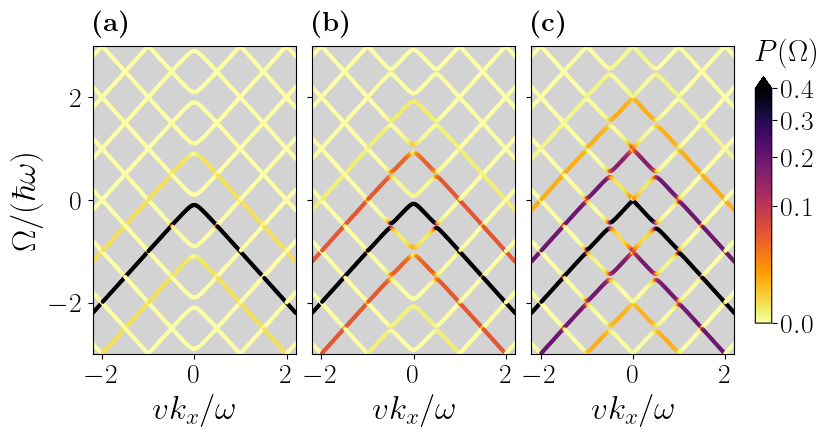

In [22]:
## Figure 1:

momentax = np.linspace(-2.2, 2.2, 201) 
Alist = [0.1, 0.5, 1.]

fig, axs = plt.subplots(1, 3, figsize=(3 * 3, 4), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.08)
for ax, Aval, cbar in zip(axs, Alist, [False, False, True]):
    par = {'k_y': 0., 'A_x': Aval, 'A_y': 0.}
    obs = ObservablesFF(hDiracFF, 'k_x', momentax, params = par)
    out = obs.photoelAmpPlot(ax = ax, Nmax=6, cbar=cbar, fig = fig, axs = axs, vmax = 0.4)
[ax.set(ylabel = None) for ax in axs[1:]]
axs[0].set(ylabel = r'$\Omega/(\hbar \omega)$', ylim = (-3,3), xlim = (-2.2, 2.2))
out[1].ax.set_title(r'', fontsize=18, y=1.2, pad=-14)
out[1].ax.set_title(r'$P(\Omega)$', fontsize=22, y=1.2, pad=-14, loc = 'left')
createletters(axs, coord = [0, 1.05])
fig.savefig(folder0+'/DOS_MassiveLinDir.pdf', bbox_inches='tight')

## Floquet t-t' formalism

In [1]:
## Define the Floquet t-t' Hamiltonian
ham_symbols = sp.symbols("v mu_sp tau_sp m", real=True)
ham_dict = {str(b): b for b in ham_symbols}
locals().update( ham_dict)

par_fix = {'v':1., 'T_p' : 1., 'm': 0.1}
params_env = {'mu_sp' : None, 'tau_sp' : None, 'A_x': None, 'A_y':0, 'A_z': 0}
params_ham = {'k_x' : None, 'k_y' : 0.0,}

hDirac_pulse = Hamiltonian_ttp(
    h0_k = v * (k_y * sx - k_x * sy) + m*sz,
    par_var_ham = params_ham,
    par_fix = par_fix,
    Vxt= sp.sin(2 * sp.pi / T_p * t_sp),
    Vyt= sp.sin(2 * sp.pi / T_p * t_sp + sp.pi / 2), 
    Axenv = A_x * sp.exp(-((t_sp-mu_sp)/(tau_sp))**2),
    Ayenv = A_y * sp.exp(-((t_sp-mu_sp)/(tau_sp))**2) , 
    ham_symbols=ham_symbols,
    N = 50) ## N is the number of Fourier replicas considered.


NameError: name 'sp' is not defined

State at t = 0.00 energy = -0.1005, wf (spinor): [-0.05+0.j     0.  -0.999j]


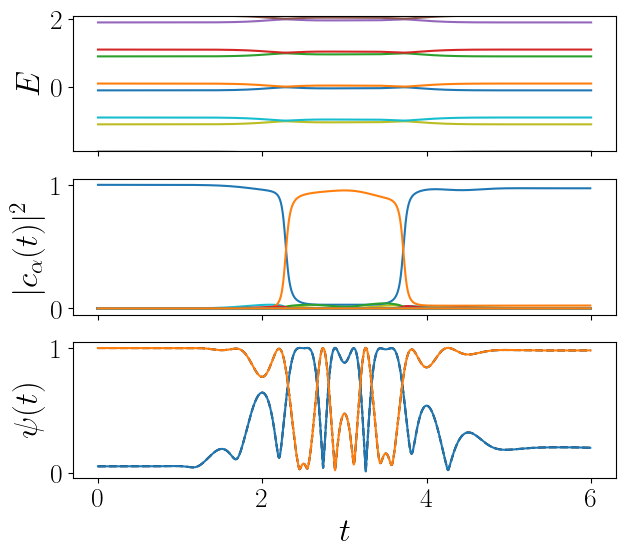

State at t = 0.00 energy = -0.1077, wf (spinor): [-0.189+0.j     0.   -0.982j]


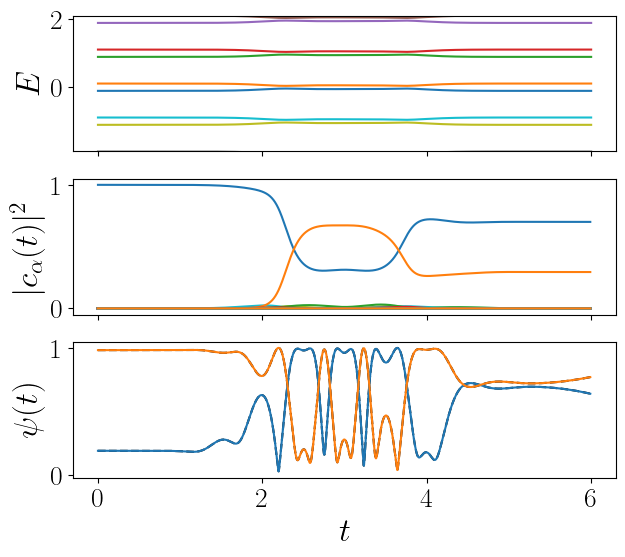

In [31]:
## Data Figure 9 ###

psi0band, T = 0, 1.
ts_fig9 = np.linspace(0, 6 * T, 8000) + 1e-6
ks = [0.01, 0.04]
A0 = 2.0

calc = True

if calc:
    solverL1 = []
    data  = []
    for ki in ks:
        params_env = {'mu_sp' : 3., 'tau_sp' : 1. , 'A_x': A0, 'A_y':0, 'A_z': 0}
        params_ham = {'k_x' : ki, 'k_y' : 0.0,}
        params_full = {**params_ham}
        solver_ki = IFS_solver(hDirac_pulse, ts_fig9, params_env, params_full, Nmax = 15)
        params_env = {'mu_sp' : 3., 'tau_sp' : 1. , 'A_x': A0, 'A_y':0, 'A_z': 0}
        params_ham = {'k_x' : ki, 'k_y' : 0.0,}
        UsC= hDirac_pulse.time_evolutionU(dict(**params_env, **params_ham, **par_fix), ts_fig9, steps = True)
        ct, psitsol = solver_ki.c_t(psi0band=psi0band, tend=5.99, psi_t=True)
        ts_ct = ts_fig9[:len(ct)]
        
        fig, axs = plt.subplots(3,1,figsize = (7, 6), sharex = True)
        axs[0].plot(ts_fig9, solver_ki.eL)
        mide = solver_ki.eL[0][len(solver_ki.eL[0])//2]
        axs[0].set(ylabel = r'$E$', xlabel = '', ylim = (mide-2, mide+2))
        axs[1].plot(ts_ct, np.abs(ct)**2)
        axs[1].set(ylabel = r'$|c_\alpha(t)|^2$', xlabel = '')
        axs[2].plot(ts_fig9, np.abs(UsC@psitsol[0]), ls = '--', c= 'k')
        axs[2].plot(ts_ct, np.abs(psitsol))
        axs[2].set(ylabel = r'$\psi(t)$', xlabel = '$t$')
        plt.show()
        data.append({'tagvec':solver_ki.tag_fqlevels(), 'indexCbase' : solver_ki.indexCbase, 'eL':solver_ki.eL, 
                     'ct':ct, 'psit':psitsol, 'psiTDSE': UsC@psitsol[0], 'ts' : ts_fig9, 
                     'ts_ct': ts_ct, **params_env, **params_ham})
    np.save(folder0+'fig_DiracMassive_calphaData', data)
else:
    data = np.load(folder0+'fig_DiracMassive_calphaData.npy', allow_pickle=True)

In [24]:
## Data for Figure 2 (a)

Axs = [1.,2.,3.,4.,5.]
psi0band, T = 0, 1 #fixed period T = 1 and band index of the initial state
ts_2a = np.linspace(1e-6, 6 * T, 4000) ## Avoid the singularity at t = 0

solverL_2a = []
ctL_2a = []
for Ax in Axs:
    params_env = {'mu_sp' : 3., 'tau_sp' : 1. , 'A_x': Ax, 'A_y':0, 'A_z': 0}
    params_ham = {'k_x' : 0.1, 'k_y' : 0.0,}
    solverL_2a.append(IFS_solver(hDirac_pulse, ts_2a, params_env, params_ham, Nmax = 12))
    ct, psitsol = solverL_2a[-1].c_t(psi0band=psi0band, tend=5.99, psi_t=True)   
    ctL_2a.append(ct)

State at t = 0.00 energy = -0.1414, wf (spinor): [-0.383+0.j     0.   -0.924j]
State at t = 0.00 energy = -0.1414, wf (spinor): [-0.383+0.j     0.   -0.924j]
State at t = 0.00 energy = -0.1414, wf (spinor): [-0.383+0.j     0.   -0.924j]
State at t = 0.00 energy = -0.1414, wf (spinor): [-0.383+0.j     0.   -0.924j]
State at t = 0.00 energy = -0.1414, wf (spinor): [-0.383+0.j     0.   -0.924j]


In [25]:
## Data for Figure 2 (b)

taus = [0.8, 1., 1.2]
ts_2b = np.linspace(0, 7.5 * T, 5000) + 1e-6

solverL_2b = []
ctL_2b = []
for tau in taus:
    params_env = {'mu_sp': 4., 'tau_sp': tau, 'A_x': 5., 'A_y': 0, 'A_z': 0}
    params_ham = {'k_x': 0.1, 'k_y': 0.0, }
    solverL_2b.append(IFS_solver(hDirac_pulse, ts_2b, params_env, params_ham, Nmax=14))
for solver in (solverL_2b):
    ct, psitsol = solver.c_t(psi0band=psi0band, tend=7, psi_t=True)
    ctL_2b.append(ct)

State at t = 0.00 energy = -0.1414, wf (spinor): [-0.383+0.j     0.   -0.924j]
State at t = 0.00 energy = -0.1414, wf (spinor): [-0.383+0.j     0.   -0.924j]
State at t = 0.00 energy = -0.1414, wf (spinor): [-0.383+0.j     0.   -0.924j]


In [26]:
## Save the data for Figure 2 
indexCbase_2a = solverL_2a[0].indexCbase
tagvec_2a  = solverL_2a[0].tag_fqlevels()
indexCbase_2b = solverL_2b[0].indexCbase
tagvec_2b  = solverL_2b[0].tag_fqlevels()
np.savez(folder0+'/fig_DiracMassive_calphaData', 
         indexCbase_2a = indexCbase_2a, indexCbase_2b = indexCbase_2b, 
         tagvec_2a = tagvec_2a, tagvec_2b=tagvec_2b, ctL_2a = ctL_2a, ctL_2b = ctL_2b, 
         taus = taus, Axs = Axs, ts_2a = ts_2a, ts_2b = ts_2b) 

<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_3346756/2256618420.py:19: SyntaxWarning: invalid escape sequence '\p'
  lab_lines = ['$(0,0)$', '$(0,\pm 1)$', '$ (0, \pm 2)$']
/tmp/ipykernel_3346756/2256618420.py:19: SyntaxWarning: invalid escape sequence '\p'
  lab_lines = ['$(0,0)$', '$(0,\pm 1)$', '$ (0, \pm 2)$']
/tmp/ipykernel_3346756/2256618420.py:21: SyntaxWarning: invalid escape sequence '\p'
  lab_lines2 = ['$(0,0)$', '$(0,\pm 1)$', '$ (0, \pm 2)$', '$ (0, \pm 3)$']
/tmp/ipykernel_3346756/2256618420.py:21: Sy

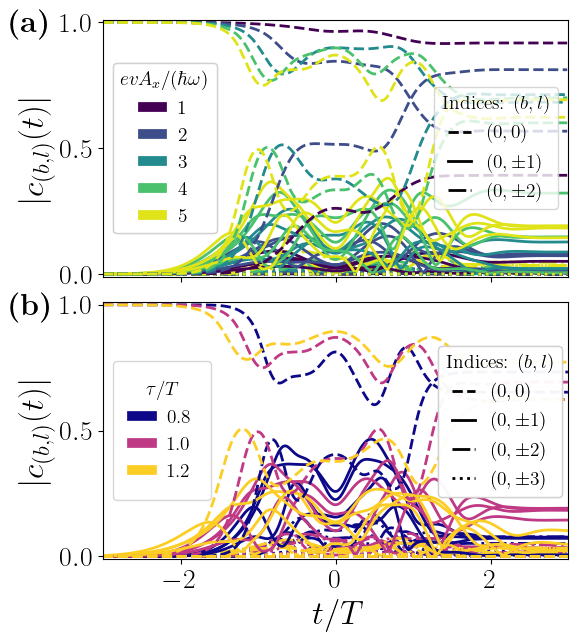

In [27]:
## Figure 2

linedict = {'0': '--', '1': '-', '2':'-.', '3': ':'}
def linestyle(m):
    if m==0:
        return '--'
    elif np.abs(m) == 1:
        return '-'
    elif np.abs(m) == 2:
        return '-.'
    else:
        return ':'
    
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6,7), sharey = True, sharex = True )
plt.subplots_adjust(hspace=0.1)

cols = cm.viridis(np.linspace(0, 0.95, len(Axs)))
lines = [Line2D([0], [0], color='k', linewidth=2, linestyle=ls)  for ls in list(linedict.values())[:-1]]
lab_lines = ['$(0,0)$', '$(0,\pm 1)$', '$ (0, \pm 2)$']
lines2 = [Line2D([0], [0], color='k', linewidth=2, linestyle=ls)  for ls in list(linedict.values())]
lab_lines2 = ['$(0,0)$', '$(0,\pm 1)$', '$ (0, \pm 2)$', '$ (0, \pm 3)$']
squaresAs = [Line2D([0], [0], color=c, linewidth=7)  for c in cols]
lab_squaresAs = [int(i) for i in Axs]


for ct, color in zip(ctL_2a, cols):
    for cti, i  in enumerate(indexCbase_2a) :
        l, m = tagvec_2a[i] 
        # label = '({},{})'.format(int(l),int(m)) if (np.max(abs(ct[:,cti]))>0.1) else None
        axs[0].plot(ts_2a[:len(ctL_2a[0])]-3, (np.abs(ct[:, cti])), lw=2, c=color, zorder = -np.abs(m), ls = linestyle(m))
lg_lines = axs[0].legend(lines, lab_lines, fontsize = 14, handlelength = 1.2, ncols = 1, loc='center right', title=r"Indices: $(b,l)$",)
lg_lines.get_title().set_fontsize('14')

lg_squares = axs[0].legend(squaresAs, lab_squaresAs, fontsize = 14, handlelength = 1., ncols = 1, loc='center left', title=r"$ev A_x/(\hbar \omega)$",)
lg_squares.get_title().set_fontsize('14')

axs[0].add_artist(lg_lines)
axs[0].add_artist(lg_squares)

cols = cm.plasma(np.linspace(0, 0.9, len(taus)))
squarestaus = [Line2D([0], [0], color=c, linewidth=7)  for c in cols]
lab_squarestaus = taus
for ct, color in zip(ctL_2b, cols):
    for cti, i  in enumerate(indexCbase_2b) :
        l, m = tagvec_2b[i] 
        # label = '({},{})'.format(int(l),int(m)) if (np.max(abs(ct[:,cti]))>0.1) else None
        axs[1].plot(ts_2b[:len(ctL_2b[0])]-4, (np.abs(ct[:, cti])), lw=2, c=color, zorder = -np.abs(m), ls = linestyle(m))

lg_squares = axs[1].legend(squarestaus, lab_squarestaus, fontsize = 14, handlelength = 1., ncols = 1, loc='center left', title=r"$\tau/T$", borderpad =1)
lg_squares.get_title().set_fontsize('14')

lg_lines = axs[1].legend(lines2, lab_lines2, fontsize = 14, handlelength = 1.2, ncols = 1, loc=(0.72, 0.24), title=r"Indices: $(b,l)$",)
lg_lines.get_title().set_fontsize('14')
axs[1].add_artist(lg_lines)
axs[1].add_artist(lg_squares)

axs[1].set(xlim=(-3,3), xlabel = r'$t/T$', ylim = (-0.01, 1.01))
[ax.set(ylabel = r'$|c_{(b,l)}(t)|$') for ax in axs]
createletters(axs, coord=[-0.2, 0.95], SMALL_SIZE=22)
fig.savefig(folder0+'/fig_DiracMassive_calpha.pdf', bbox_inches='tight', transparent = True)

State at t = 0.00 energy = -0.1414, wf (spinor): [-0.383+0.j     0.   -0.924j]
State at t = 0.00 energy = -0.1414, wf (spinor): [-0.383+0.j     0.   -0.924j]
State at t = 0.00 energy = -0.1414, wf (spinor): [-0.383+0.j     0.   -0.924j]
State at t = 0.00 energy = -0.1414, wf (spinor): [-0.383+0.j     0.   -0.924j]
State at t = 0.00 energy = -0.1414, wf (spinor): [-0.383+0.j     0.   -0.924j]


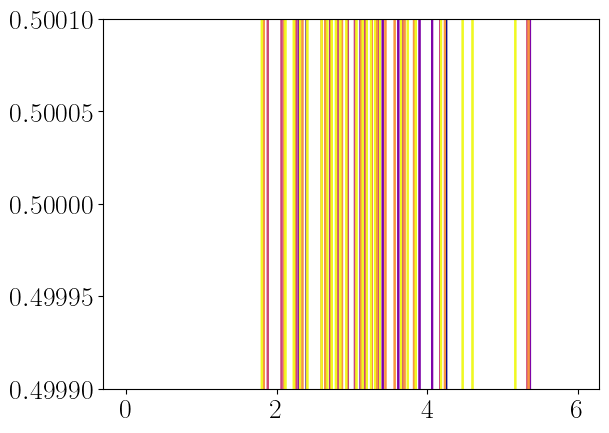

State at t = 0.00 energy = -0.1414, wf (spinor): [-0.383+0.j     0.   -0.924j]
State at t = 0.00 energy = -0.1414, wf (spinor): [-0.383+0.j     0.   -0.924j]
State at t = 0.00 energy = -0.1414, wf (spinor): [-0.383+0.j     0.   -0.924j]


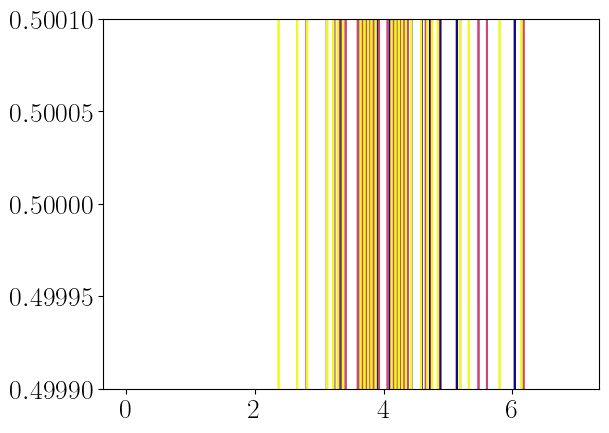

In [ ]:
## Check plot
cols = cm.plasma(np.linspace(0, 1, len(solverL_2a)))
for solver, color in zip(solverL_2a, cols):
    ct, psitsol = solver.c_t(psi0band=psi0band, tend=5.99, psi_t=True)
    plt.plot(ts_2a[:len(ct)], np.abs(psitsol) ** 2, c=color)
plt.ylim(0.5-1e-4, 0.5+1e-4)
plt.show()

cols = cm.plasma(np.linspace(0, 1, len(solverL_2b)))
for solver, color in zip(solverL_2b, cols):
    ct, psitsol = solver.c_t(psi0band=psi0band, tend=7, psi_t=True)
    plt.plot(ts_2b[:len(ct)], np.abs(psitsol) ** 2, c=color)
plt.ylim(0.5-1e-4, 0.5+1e-4)
plt.show()


In [12]:
## Data Figura 3
### For the linear Dirac model we need to calculate this for an arbitrary kx (it is k independent) and the spectrum is also not changing with the amplitude, so just one Ax value is fine
T = 1
ts3 = np.linspace(0, 7.5 * T, 5000) + 1e-6
params_env = {'mu_sp': 4., 'tau_sp': 0.8, 'A_x': 5., 'A_y': 0, 'A_z': 0}
params_ham = {'k_x': 0.1, 'k_y': 0.0, }
solver = (IFS_solver(hDirac_pulse, ts3, params_env, params_ham, Nmax=10))
indexCbase = solver.indexCbase
tagvec  = solver.tag_fqlevels()
ct, psitsol = solver.c_t(psi0band=0, tend=7, psi_t=True)

momentax = np.linspace(-2.2, 2.2, 201) 
par = {'k_y': 0., 'A_x': 1e-4, 'A_y': 0.}
eL = np.array([-np.abs(momentax), np.abs(momentax)]).T

State at t = 0.00 energy = -0.1414, wf (spinor): [-0.383+0.j     0.   -0.924j]


[0.10539922 0.69767633 1.        ]
[-1.2  -0.48  0.  ]


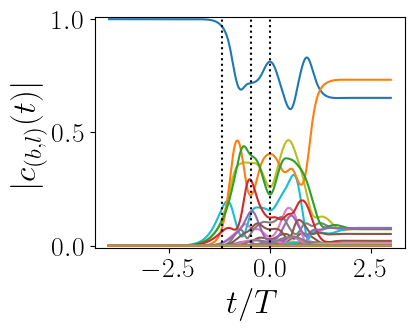

In [13]:
##### Select the three time snapshots
t_sel = np.array([2.8, 3.52, 4])
inds_t = [np.argmin(np.abs(ts3-ti)) for ti in t_sel]
Axfunct = sp.lambdify(t_sp, (hDirac_pulse.Axenv).evalf(subs={hDirac_pulse.ham_dict[key]:val for key, val in params_env.items()}))
Alist = Axfunct(t_sel)
fig, ax = plt.subplots(1, 1, figsize = (4,3))
plt.plot(ts3[:len(ct)]-4., np.abs(ct))
[plt.axvline(i-4, color ='k', ls =':') for i in t_sel]
ax.set(xlabel = r'$t/T$', ylim = (-0.01, 1.01))
ax.set(ylabel = r'$|c_{(b,l)}(t)|$')
print(Alist/5) 
print(t_sel-4.)

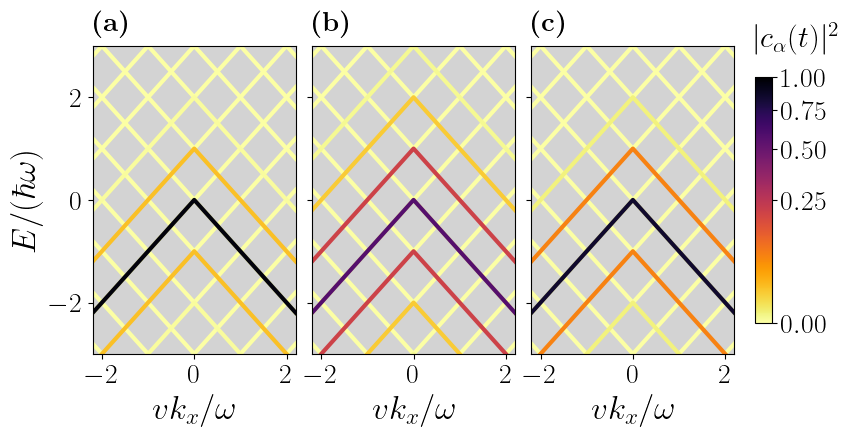

In [14]:
## Figure 3
cmap = mpl.colormaps['inferno_r']
norm = mpl.colors.PowerNorm(vmin = 0, vmax = 1, gamma = 0.5)

fig, axs = plt.subplots(1, 3, figsize=(3 * 3, 4), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.08)

for ti, ax in zip(inds_t, axs):
    for cti, i  in enumerate(indexCbase):
        l, m = tagvec[i]
        z1 = ax.plot(momentax, eL[:,int(l)%2] + m, 
                     c = cmap(norm(np.abs(ct[ti, cti])**2)), 
                     zorder = np.abs(ct[ti, cti]), lw = 3)
        z1 = ax.scatter(-10, -10, 
                     c = (np.abs(ct[ti, cti])**2), cmap = cmap, norm = norm)
    ax.set(facecolor='lightgrey', xlabel=(r'$vk_x/\omega$'))
axs[0].set(ylabel = r'$E/(\hbar \omega)$', ylim = (-3,3), xlim = (-2.2, 2.2))
cbar_ax = fig.colorbar(z1, ax=axs, pad=0.03, shrink=0.8, aspect=15, fraction=0.05)
cbar_ax.ax.set_title(r'$|c_\alpha(t)|^2$', fontsize=22, y=1.2, pad=-14, loc = 'left')
createletters(axs, coord = [0, 1.05])
fig.savefig(folder0+'/FigsPaper/Spectrum_DiracLin_cs.pdf', bbox_inches='tight')